In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

In [2]:
df = pd.read_csv('/content/train_data.csv')

In [3]:
df

,Period Code,Cycle ID,B_2,B_3,B_4,B_5,B_9,B_10,B_14,B_15,...,B_18,B_19,B_20,B_21,B_22,B_23,B_24,B_25,Good/Bad,timestamp
0,1,1,-0.0007,-0.0004,100,518.67,14.62,21.61,1.3,47.47,...,8138.62,8.4195,0.03,392,2388,100,39.06,23.419,0,3/1/2020 0:00
1,1,2,0.0019,-0.0003,100,518.67,14.62,21.61,1.3,47.49,...,8131.49,8.4318,0.03,392,2388,100,39,23.4236,0,3/1/2020 0:05
2,1,3,-0.0043,0.0003,100,518.67,14.62,21.61,1.3,47.27,...,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,0,3/1/2020 0:10
3,1,4,0.0007,0,100,518.67,14.62,21.61,1.3,47.13,...,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,0,3/1/2020 0:15
4,1,5,-0.0019,-0.0002,100,518.67,14.62,21.61,1.3,47.28,...,8133.8,8.4294,0.03,393,2388,100,38.9,23.4044,0,3/1/2020 0:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16499,82,122,-0.0001,0.0002,100,518.67,14.62,21.61,1.3,47.48,...,8163.51,8.4098,0.03,392,2388,100,38.88,23.3777,0,4/27/2020 6:55
16500,82,123,0.0016,0.0002,100,518.67,14.62,21.6,1.3,47.15,...,8153.63,8.3746,0.03,392,2388,100,38.89,23.3542,0,4/27/2020 7:00
16501,82,124,Missing,-0.0005,100,518.67,14.62,21.61,1.3,47.48,...,8162.75,8.414,0.03,391,2388,100,38.9,23.3692,0,4/27/2020 7:05
16502,82,125,0.0001,-0.0002,100,518.67,14.62,21.6,1.3,47.12,...,8150.24,8.4058,0.03,391,2388,100,38.99,23.4025,0,4/27/2020 7:10


In [4]:
df.shape

(16504, 22)

In [5]:
df.columns

Index(['Period Code', 'Cycle ID', 'B_2', 'B_3', 'B_4', 'B_5', 'B_9', 'B_10',
       'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22',
       'B_23', 'B_24', 'B_25', 'Good/Bad', 'timestamp'],
      dtype='object')

In [6]:
df.dtypes

Period Code    object
Cycle ID       object
B_2            object
B_3            object
B_4            object
B_5            object
B_9            object
B_10           object
B_14           object
B_15           object
B_16           object
B_17           object
B_18           object
B_19           object
B_20           object
B_21           object
B_22           object
B_23           object
B_24           object
B_25           object
Good/Bad       object
timestamp      object
dtype: object

In [7]:
df.isnull().sum()

Period Code    29
Cycle ID       36
B_2            40
B_3            44
B_4            42
B_5            35
B_9            29
B_10           44
B_14           44
B_15           46
B_16           37
B_17           41
B_18           35
B_19           37
B_20           40
B_21           29
B_22           27
B_23           31
B_24           41
B_25           37
Good/Bad       39
timestamp       0
dtype: int64

In [8]:
df_filtered = df.drop(["Period Code", "Cycle ID", "B_4", "B_5", "B_9", "B_10", "B_14","B_20", "B_22", "B_23"], axis=1)
df_filtered.head()

,B_2,B_3,B_15,B_16,B_17,B_18,B_19,B_21,B_24,B_25,Good/Bad,timestamp
0,-0.0007,-0.0004,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.419,0,3/1/2020 0:00
1,0.0019,-0.0003,47.49,522.28,2388.07,8131.49,8.4318,392,39,23.4236,0,3/1/2020 0:05
2,-0.0043,0.0003,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0,3/1/2020 0:10
3,0.0007,0,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0,3/1/2020 0:15
4,-0.0019,-0.0002,47.28,522.19,2388.04,8133.8,8.4294,393,38.9,23.4044,0,3/1/2020 0:20


In [9]:
outliers = ['Bad', 'no connection', 'stop', 'Missing', 'start', 'No data', 'No Data', 'no connection', 'I/O', 'no response', 'NaN']

In [10]:
column_list = ["B_2", "B_3","B_15", "B_16", "B_17", "B_18", "B_19", "B_21", "B_24", "B_25", "Good/Bad"]
for i in column_list:
  for j in outliers:
    df_filtered.loc[df_filtered[i] == j, i] = np.nan
  df_filtered[i].fillna(method = "ffill", inplace=True)
  print(df_filtered[i].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0


In [11]:
(df_filtered["B_2"] == "Bad").sum()

0

In [12]:
df_filtered.shape

(16504, 12)

In [13]:
numeric_columns = ["B_2", "B_3","B_15", "B_16", "B_17", "B_18", "B_19", "B_21", "B_24", "B_25", "Good/Bad"]

for i in numeric_columns:
  df_filtered[i] = pd.to_numeric(df_filtered[i])

df_filtered.dtypes

B_2          float64
B_3          float64
B_15         float64
B_16         float64
B_17         float64
B_18         float64
B_19         float64
B_21           int64
B_24         float64
B_25         float64
Good/Bad       int64
timestamp     object
dtype: object

In [14]:
#sns.pairplot(df_filtered, hue = "Good/Bad")

In [15]:
from datetime import datetime, timedelta

df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
df_filtered['timestamp'] = df_filtered['timestamp'].dt.strftime('%m/%d/%Y %H:%M')

df_filtered

,B_2,B_3,B_15,B_16,B_17,B_18,B_19,B_21,B_24,B_25,Good/Bad,timestamp
0,-0.0007,-0.0004,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0,03/01/2020 00:00
1,0.0019,-0.0003,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0,03/01/2020 00:05
2,-0.0043,0.0003,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0,03/01/2020 00:10
3,0.0007,0.0000,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0,03/01/2020 00:15
4,-0.0019,-0.0002,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0,03/01/2020 00:20
...,...,...,...,...,...,...,...,...,...,...,...,...
16499,-0.0001,0.0002,47.48,521.37,2388.05,8163.51,8.4098,392,38.88,23.3777,0,04/27/2020 06:55
16500,0.0016,0.0002,47.15,522.09,2388.05,8153.63,8.3746,392,38.89,23.3542,0,04/27/2020 07:00
16501,0.0016,-0.0005,47.48,522.52,2388.00,8162.75,8.4140,391,38.90,23.3692,0,04/27/2020 07:05
16502,0.0001,-0.0002,47.12,522.38,2388.00,8150.24,8.4058,391,38.99,23.4025,0,04/27/2020 07:10


In [16]:
#df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')

# Extract day, month, year, hours, minutes, and seconds into separate columns
#df_filtered['day'] = df_filtered['timestamp'].dt.day
#df_filtered['month'] = df_filtered['timestamp'].dt.month
#df_filtered['year'] = df_filtered['timestamp'].dt.year
#df_filtered['hour'] = df_filtered['timestamp'].dt.hour
#df_filtered['minute'] = df_filtered['timestamp'].dt.minute
#df_filtered['second'] = df_filtered['timestamp'].dt.second

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a target column 'Good/Bad' with 0 or 1
X = df_filtered[['B_2', 'B_3', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_24', 'B_25']]
y = df_filtered['Good/Bad']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)

# Train a random forest classifier (you can choose a different classifier)
clf = RandomForestClassifier(n_estimators=95, random_state=11)
clf.fit(X_train, y_train)

# Predict 'Good/Bad' labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the classification model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report for more detailed evaluation
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9583491101855358
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4457
           1       0.89      0.84      0.86       825

    accuracy                           0.96      5282
   macro avg       0.93      0.91      0.92      5282
weighted avg       0.96      0.96      0.96      5282



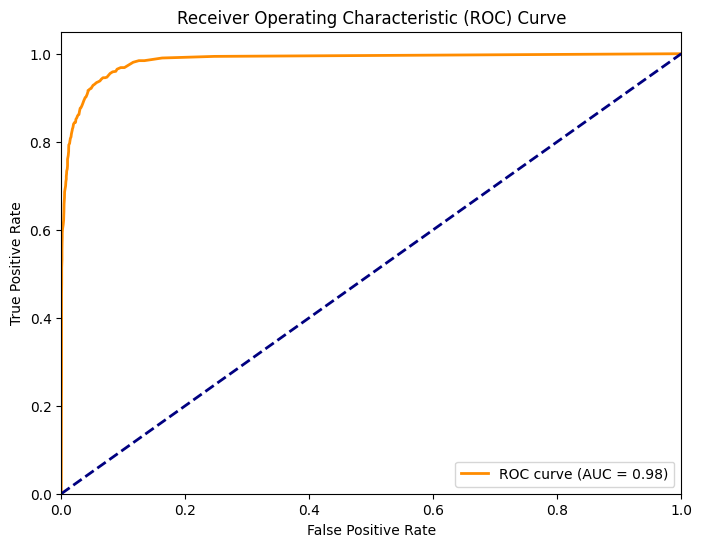

AUC (Area Under the ROC Curve): 0.9844708697928352


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (good cycles)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print("AUC (Area Under the ROC Curve):", roc_auc)

In [19]:
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels in y_test (0 for "bad," 1 for "good")

# Get model predictions
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Extract TP, TN, FP, FN
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Print TP, TN, FP, FN
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)


Confusion Matrix:
[[4369   88]
 [ 132  693]]
True Positives (TP): 693
True Negatives (TN): 4369
False Positives (FP): 88
False Negatives (FN): 132


In [20]:
df_test = pd.read_csv('/content/test_data.csv')

In [21]:
df_filtered_test = df_test.drop(["Period Code", "B_4", "B_5", "B_9", "B_10", "B_14","B_20", "B_22", "B_23"], axis=1)
df_filtered_test.head()

,Cycle ID,B_2,B_3,B_15,B_16,B_17,B_18,B_19,B_21,B_24,B_25,timestamp
0,127,-0.0014,-0.0003,47.28,521.83,2388.04,8158.04,8.4314,393,39.07,23.28,4/27/2020 7:20
1,128,-0.0003,0.0003,47.35,521.84,2388.02,8154.69,8.3897,391,38.8,23.3672,4/27/2020 7:25
2,129,-0.002,0,47.2,522.02,2388.01,8152.23,8.4298,392,38.87,23.3531,4/27/2020 7:30
3,130,no response,-0.0002,47.4,521.67,2388,8158.26,8.4078,391,39.02,23.2821,4/27/2020 7:35
4,Bad,-0.0011,0.0003,47.31,521.8,2388.01,8154.09,8.449,391,38.89,23.2888,4/27/2020 7:40


In [22]:
column_list = ["B_2", "B_3","B_15", "B_16", "B_17", "B_18", "B_19", "B_21", "B_24", "B_25"]
for i in column_list:
  for j in outliers:
    df_filtered_test.loc[df_filtered_test[i] == j, i] = np.nan
  df_filtered_test[i].fillna(method = "ffill", inplace=True)
  print(df_filtered_test[i].isnull().sum())

0
0
0
0
0
0
0
0
0
0


In [23]:
numeric_columns = ["B_2", "B_3","B_15", "B_16", "B_17", "B_18", "B_19", "B_21", "B_24", "B_25"]

for i in numeric_columns:
  df_filtered_test[i] = pd.to_numeric(df_filtered_test[i])

df_filtered_test.dtypes

Cycle ID      object
B_2          float64
B_3          float64
B_15         float64
B_16         float64
B_17         float64
B_18         float64
B_19         float64
B_21           int64
B_24         float64
B_25         float64
timestamp     object
dtype: object

In [24]:
#df_filtered_test["Cycle ID"].fillna("nan", inplace=True)

In [25]:
#df_filtered_test['timestamp'] = pd.to_datetime(df_filtered_test['timestamp'], errors='coerce')

# Extract day, month, year, hours, minutes, and seconds into separate columns
#df_filtered_test['day'] = df_filtered_test['timestamp'].dt.day
#df_filtered_test['month'] = df_filtered_test['timestamp'].dt.month
#df_filtered_test['year'] = df_filtered_test['timestamp'].dt.year
#df_filtered_test['hour'] = df_filtered_test['timestamp'].dt.hour
#df_filtered_test['minute'] = df_filtered_test['timestamp'].dt.minute
#df_filtered_test['second'] = df_filtered_test['timestamp'].dt.second

In [26]:
X_test_data = df_filtered_test[['B_2', 'B_3', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_24', 'B_25']]

In [27]:
y_pred_test = clf.predict(X_test_data)

In [28]:
d = {"ID": df_filtered_test["timestamp"].astype(str) + "-" + df_filtered_test["Cycle ID"].astype(str), "Good/Bad": y_pred_test}

In [29]:
d

{'ID': 0        4/27/2020 7:20-127
 1        4/27/2020 7:25-128
 2        4/27/2020 7:30-129
 3        4/27/2020 7:35-130
 4        4/27/2020 7:40-Bad
                ...         
 4122    5/11/2020 14:50-196
 4123    5/11/2020 14:55-197
 4124    5/11/2020 15:00-198
 4125    5/11/2020 15:05-199
 4126    5/11/2020 15:10-200
 Length: 4127, dtype: object,
 'Good/Bad': array([0, 0, 0, ..., 1, 1, 1])}

In [30]:
df_submission = pd.DataFrame(data = d)

In [31]:
df_submission

,ID,Good/Bad
0,4/27/2020 7:20-127,0
1,4/27/2020 7:25-128,0
2,4/27/2020 7:30-129,0
3,4/27/2020 7:35-130,0
4,4/27/2020 7:40-Bad,0
...,...,...
4122,5/11/2020 14:50-196,1
4123,5/11/2020 14:55-197,1
4124,5/11/2020 15:00-198,1
4125,5/11/2020 15:05-199,1


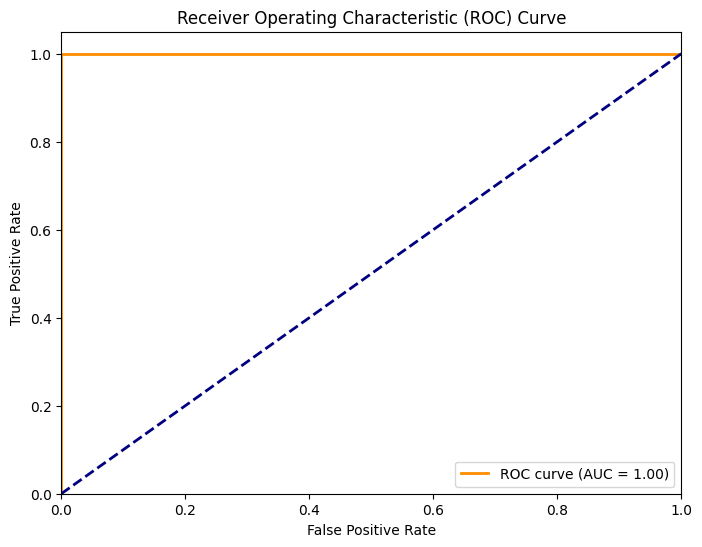

AUC (Area Under the ROC Curve): 1.0


In [32]:
# Get predicted probabilities for class 1 (good cycles)
y_pred_test_prob = clf.predict_proba(X_test_data)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_pred_test, y_pred_test_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_pred_test, y_pred_test_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print("AUC (Area Under the ROC Curve):", roc_auc)

In [33]:
df_submission["ID"] = df_submission["ID"].astype(str)

In [34]:
df_submission.to_csv("output.csv", index=False)

In [35]:
df_submission.dtypes

ID          object
Good/Bad     int64
dtype: object